Usage: java [-options] class [args...]
           (to execute a class)
   or  java [-options] -jar jarfile [args...]
           (to execute a jar file)
where options include:
    -d32	  use a 32-bit data model if available
    -d64	  use a 64-bit data model if available
    -server	  to select the "server" VM
                  The default VM is server,
                  because you are running on a server-class machine.


    -cp <class search path of directories and zip/jar files>
    -classpath <class search path of directories and zip/jar files>
                  A : separated list of directories, JAR archives,
                  and ZIP archives to search for class files.
    -D<name>=<value>
                  set a system property
    -verbose:[class|gc|jni]
                  enable verbose output
    -version      print product version and exit
    -version:<value>
                  in a future release.
                  require the specified version to run
    -showversion  print

/var/folders/4g/m6zlx10d129gwpdh6q4rlrcc0000gn/T/ipykernel_57633/349980482.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(local_file, index_col=0, parse_dates=True)


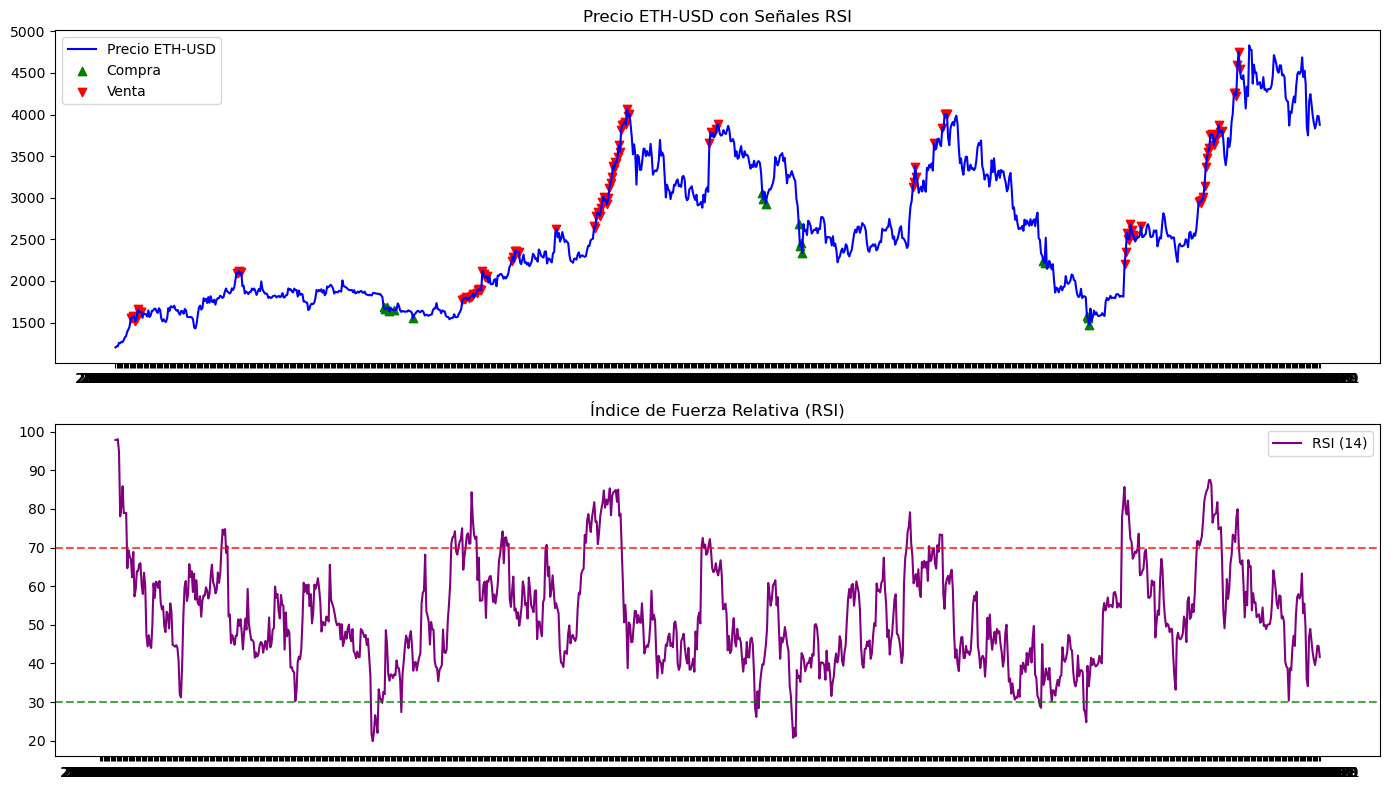


Capital final simulado: 1058.96 USD
Retorno total: 5.90%


In [ ]:
# --- INSTALACIÓN DE PAQUETES ---
%pip install -U yfinance pycoingecko ccxt -q

# --- IMPORTS ---
import datetime 
import time 
import ccxt 
import os
import ta
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI

# --- FUNCIÓN PARA DESCARGAR DATOS DE ETH ---
def get_eth_data(start="2024-01-01", end="2026-01-28", local_file="eth_data.csv"):
    """Descarga datos de ETH-USD desde Yahoo Finance. 
       Si falla, intenta desde CoinGecko. Si existe un archivo local, lo carga primero."""
    
    # Si ya existe un archivo local, cargarlo
    if os.path.exists(local_file):
        print(f"Cargando datos locales desde '{local_file}'...")
        data = pd.read_csv(local_file, index_col=0, parse_dates=True)
        return data

    # Intentar con Yahoo Finance
    try:
        print("Intentando descargar desde Yahoo Finance...")
        data = yf.download("ETH-USD", start=start, end=end)
        if data.empty:
            raise ValueError("Yahoo devolvió dataset vacío.")
        print("Datos descargados exitosamente desde Yahoo Finance.")
        data.to_csv(local_file)
        return data
    except Exception as e:
        print(f"Error con Yahoo Finance: {e}")
        print("Intentando obtener datos desde CoinGecko...")

        # Fallback: CoinGecko
        try:
            cg = CoinGeckoAPI()
            eth_data = cg.get_coin_market_chart_by_id(id='ethereum', vs_currency='usd', days='max')
            data = pd.DataFrame(eth_data['prices'], columns=['Timestamp', 'Close'])
            data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='ms')
            data.set_index('Timestamp', inplace=True)

            print("Datos obtenidos exitosamente desde CoinGecko.")
            data.to_csv(local_file)
            return data
        except Exception as e2:
            print(f"Error también con CoinGecko: {e2}")
            raise Exception("No se pudieron obtener datos de ninguna fuente.")

# --- DESCARGAR DATOS ---
data = get_eth_data()

# Asegurar que 'Close' sea numérico (soluciona el problema de strings)
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Opcional: eliminar filas con NaN en Close (si hubo errores de conversión)
data = data.dropna(subset=['Close'])

# --- CALCULAR RSI ---
close_series = data['Close'].squeeze()
rsi_indicator = ta.momentum.RSIIndicator(close=close_series, window=14)
data['RSI'] = rsi_indicator.rsi()

# --- GENERAR SEÑALES DE COMPRA/VENTA ---
data['Buy_Signal'] = (data['RSI'] < 30)
data['Sell_Signal'] = (data['RSI'] > 70)

# --- GRAFICAR PRECIO + RSI ---
plt.figure(figsize=(14,8))

# Precio con señales
plt.subplot(2,1,1)
plt.plot(data['Close'], label='Precio ETH-USD', color='blue')
plt.scatter(data.index[data['Buy_Signal']], data['Close'][data['Buy_Signal']], marker='^', color='green', label='Compra', alpha=1)
plt.scatter(data.index[data['Sell_Signal']], data['Close'][data['Sell_Signal']], marker='v', color='red', label='Venta', alpha=1)
plt.title('Precio ETH-USD con Señales RSI')
plt.legend()

# RSI
plt.subplot(2,1,2)
plt.plot(data['RSI'], color='purple', label='RSI (14)')
plt.axhline(70, linestyle='--', color='red', alpha=0.7)
plt.axhline(30, linestyle='--', color='green', alpha=0.7)
plt.title('Índice de Fuerza Relativa (RSI)')
plt.legend()

plt.tight_layout()
plt.show()

# --- SIMULACIÓN SIMPLE DE ESTRATEGIA ---
capital = 1000  # USD inicial
eth_owned = 0.0

for i in range(1, len(data)):
    buy = bool(data['Buy_Signal'].iloc[i])
    sell = bool(data['Sell_Signal'].iloc[i])
    
    if buy and capital > 0:
        eth_owned = capital / data['Close'].iloc[i]
        capital = 0.0
        # Opcional: print(f"Compra en {data.index[i].date()} @ {data['Close'].iloc[i]:.2f}")
    elif sell and eth_owned > 0:
        capital = eth_owned * data['Close'].iloc[i]
        eth_owned = 0.0
        # Opcional: print(f"Venta en {data.index[i].date()} @ {data['Close'].iloc[i]:.2f}")

# Cierre final (si quedó en ETH)
if eth_owned > 0:
    capital = eth_owned * data['Close'].iloc[-1]

print(f"\nCapital final simulado: {capital:.2f} USD")
print(f"Retorno total: {(capital - 1000) / 1000 * 100:.2f}%")
